In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plit
import seaborn as sns
from matplotlib import pyplot as plt

from collections import Counter

#from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import FunctionTransformer

# Managing Categorical Data
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder    
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer

# Managing Missing Values
from sklearn.base import BaseEstimator, TransformerMixin

# Make a pipeline
from sklearn.pipeline import Pipeline, make_pipeline

# Scaling
from sklearn.preprocessing import StandardScaler

#Models
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

#Classifier Validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#ensable models
from sklearn.ensemble import VotingClassifier

# Learning Curve
from sklearn.model_selection import learning_curve

# Titanic - Machine Learning from Disaster
### Mitko Stoychev

31/03/2024

1. Introduction
2. EDA & Feature Engeneering
* 2.1. Loading the data
* 2.2. Outlier detection
* 2.3. Exploration


    
2.2 
2.3 joining train and test set
2.4 check for null and missing values

3 Feature analysis
3.1 Numerical values
3.2 Categorical values

4 Filling missing Values
4.1 Age

5 Feature engineering
5.1 Name/Title
5.2 Family Size
5.3 Cabin
5.4 Ticket

6 Modeling
6.1 Simple modeling
6.1.1 Cross validate models
6.1.2 Hyperparamater tunning for best models
6.1.3 Plot learning curves
6.1.4 Feature importance of the tree based classifiers
6.2 Ensemble modeling
6.2.1 Combining models
6.3 Prediction
6.3.1 Predict and Submit results

## 1. Introduction
This is my first machine learning model and my first Kaggle competition at same time. I choosed the Titanic competition which is a good way to introduce feature engineering and ensemble modeling.
Firstly, I will explore the dataset and display some feature analyses, then I´ll focus on the feature engineering. The last part of the project concerns modeling and predicting the survival on the Titanic.


This notebook has three main main parts:
* **EDA & Feature Engeneering**
* **Data preparation**
* **Modeling**

## 2.EDA & Feature Engeneering
### 2.1. Loading the data

In [2]:
train_data = pd.read_csv("data/train.csv")
test_data = pd.read_csv("data/test.csv")

print(train_data.shape)
print(test_data.shape)

train_data.head()

(891, 12)
(418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### 2.2. Outlier detection

**Tukey’s method** is widely used for exploratory data analysis and has become a standard approach for identifying outliers in statistical and data analysis practices. John Tukey looks at the data’s spread using the Interquartile Range (IQR). 

Tukey defined outliers as those points that fall **below Q1 – 1.5*IQR** or **above Q3 + 1.5*IQR**, providing a clear, quantitative criterion for identifying data points that are significantly different from the bulk of the data in a set.

In [3]:
def outlier_detection(data, features):
    """
    Takes a dataframe and a list of the columns that is decided to apply Tukey´s method for detecting outliers.
    Returns a list of indices that are considered outliers.
    """
    outlier_indices = []
    n = 2 # treshold
    
    # Iterate over each feature
    for col in features:
        # Calculate quartiles
        Q1 = np.percentile(data[col], 25)
        Q3 = np.percentile(data[col], 75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # Outlier step
        outlier_step = 1.5 * IQR
        
        # Determine the index of the outliers for feature col
        outlier_list_col = data[(data[col] < Q1 - outlier_step) | (data[col] > Q3 + outlier_step)].index
        
        # Append indices of outliers for every col 
        outlier_indices.extend(outlier_list_col)
        
    # Count occurrences of each index
    outlier_count = Counter(outlier_indices)
    
    # Select indices with more than n outliers
    multiple_outliers = [index for index, count in outlier_count.items() if count > n]
    
    return multiple_outliers

In [4]:
outliers_to_drop = outlier_detection(train_data, ["Age", "SibSp", "Parch", "Fare"])
outliers_to_drop

[27, 88, 159, 180, 201, 324, 341, 792, 846, 863]

In [5]:
train_data.loc[outliers_to_drop]  # show the detected outliers

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


I have detected 10 outliers.

The next three passengers: 28, 89 and 342 → outliers because of high Ticket Fare.

The remaining seven passengers → high values # of siblings.P.

In [6]:
# Drop outliers
train_data_outliers = train_data.copy()  # save the original dataset

train_data = train_data.drop(outliers_to_drop, axis=0).reset_index(drop=True)

print(train_data_outliers.shape)
print(train_data.shape)

(891, 12)
(881, 12)


### 2.3. Exploration

In [7]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


          Survived     SibSp     Parch       Age      Fare
Survived  1.000000  0.003330  0.092819 -0.076867  0.264613
SibSp     0.003330  1.000000  0.379281 -0.307129  0.110072
Parch     0.092819  0.379281  1.000000 -0.186457  0.183801
Age      -0.076867 -0.307129 -0.186457  1.000000  0.110219
Fare      0.264613  0.110072  0.183801  0.110219  1.000000


<Axes: >

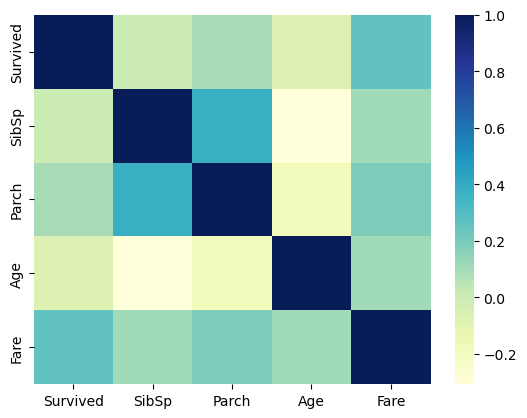

In [8]:
print(train_data[["Survived","SibSp","Parch","Age","Fare"]].corr())

sns.heatmap(train_data[["Survived","SibSp","Parch","Age","Fare"]].corr(), cmap="YlGnBu")

With the **Pearon Correlation method** is seems that only "Fare" feature seem to have some correlation with the survival probability.

It **doesn't mean that the other features are not usefull**. Subpopulations in these features can be correlated with the survival. To determine this, we need to explore in detail these features.

Let´s explore them by grouping.

In [9]:
# Grouping data by Ticket class
train_data.groupby(["Pclass"], as_index=False)["Survived"].mean()

,Pclass,Survived
0,1,0.629108
1,2,0.472826
2,3,0.245868


In [10]:
# Groping data by Sex
train_data.groupby(["Sex"], as_index=False)["Survived"].mean()

,Sex,Survived
0,female,0.747573
1,male,0.190559


In [11]:
# Grouping by Embarked → Port of Embarkation
# C = Cherbourg, Q = Queenstown, S = Southampton

train_data.groupby(["Embarked"], as_index=False)["Survived"].mean()

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339117


In [12]:
# number of siblings / spouses aboard the Titanic
train_data.groupby(["SibSp"], as_index=False)["Survived"].mean()

,SibSp,Survived
0,0,0.345395
1,1,0.535885
2,2,0.464286
3,3,0.153846
4,4,0.166667
5,5,0.000000


In [13]:
# number of parents / children aboard the Titani
train_data.groupby(["Parch"], as_index=False)["Survived"].mean()

,Parch,Survived
0,0,0.343658
1,1,0.550847
2,2,0.542857
3,3,0.600000
4,4,0.000000
5,5,0.200000
6,6,0.000000


C:\Users\Mitko Stoychev\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


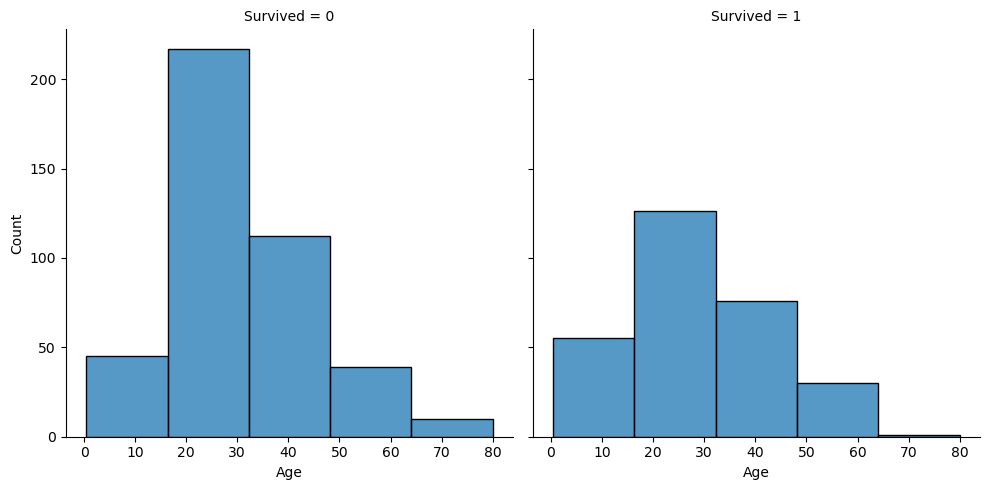

In [14]:
# Grouping by Age 
sns.displot(train_data, x="Age", col="Survived", bins=5)

In [15]:
# Create Family Size Column  →  + 1 for youself
train_data["family_size"] = train_data["SibSp"] + train_data["Parch"] + 1
train_data_outliers["family_size"] = train_data_outliers["SibSp"] + train_data_outliers["Parch"] + 1

#Don´t forget to add in in the test_data too
test_data["family_size"] = test_data["SibSp"] + test_data["Parch"] + 1

# Grouping by the Family Size
train_data.groupby(["family_size"], as_index=False)["Survived"].mean()

,family_size,Survived
0,1,0.303538
1,2,0.552795
2,3,0.578431
3,4,0.724138
4,5,0.200000
5,6,0.052632
6,7,0.333333
7,8,0.000000


C:\Users\Mitko Stoychev\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


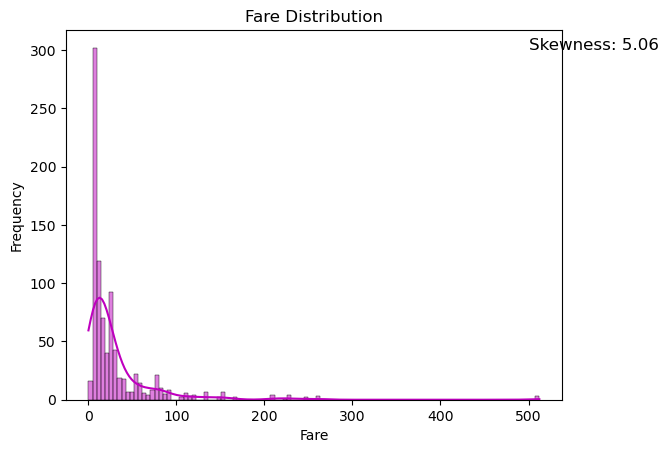

In [16]:
# Exploring Fare Distribution
sns.histplot(train_data["Fare"], color="m", kde=True)
plt.title("Fare Distribution")
plt.xlabel("Fare")
plt.ylabel("Frequency")
plt.text(500, 300, "Skewness: %.2f" % train_data["Fare"].skew(), fontsize=12)
plt.show()

As we can see, Fare distribution is very skewed to the left. This can lead to overweigth very high values in the model, even if it is scaled.

In this case, it is better to transform it with the log function to reduce it´s skew.

$$log1p = log(1+x)$$

Remember to perform the inverse transformation to obtain the original value:

$$expm1 = exp(x) - 1$$

This process is done in the point → *2.3. Scaling the data*.

## 2. Data preparation
In this section I´m going to manage the missing values, drop the unnesarry features and encode the categorical data.

0.   PassengerId  → 881 non-null    → int64    → OK
1.   Survived     → 881 non-null    → int64    → OK
2.   Pclass       → 881 non-null    → int64    → OK (categorical data but already transformed like encoded ordinal data)
3.   Name         → 881 non-null    → object   → **NOT OK** (categorical data → drop the column)
4.   Sex          → 881 non-null    → object    → **NOT OK** (categorical data → encode to numerical)
5.   Age          → 711 non-null    → float64   → **NOT OK** (missing values → fill with arithmetic mean)
6.   SibSp        → 881 non-null    → int64     → OK
7.   Parch        → 881 non-null    → int64     → OK
8.   Ticket       → 881 non-null    → object    → **NOT OK** (categorical data → drop the column)
9.   Fare         → 881 non-null    → float64   → OK (check for skewness)
10.  Cabin        → 201 non-null    → object    → **NOT OK** (missing values → drop the column)
11.  Embarked     → 879 non-null    → object    → **NOT OK** (categorical data → encode to numerical)
12.  family_size  → 881 non-null    → int64     → OK

In [17]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
 12  family_size  881 non-null    int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 89.6+ KB


In [18]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
 11  family_size  418 non-null    int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 39.3+ KB


### 2.1. Filling null values
The missing values are in the columns:
* Age → 570 non-null of 720 total values → fill with the arithmetic mean
* Cabin → Just remove the column → not relevant for my simplified model
* Fare → (**test_data**) → fill with median
* Embarked → fill it with the most common value.

In [19]:
class AgeImputer(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):  # Since we don´t have really to do any fitting here
        return self            # We´re going to return just the self object because fit function → returns BaseEstimator itself
    
    def transform(self, X):
        imputer = SimpleImputer(strategy="mean")
        X["Age"] = imputer.fit_transform(X[["Age"]])
        return X

In [20]:
train_data.drop(["Cabin"], axis=1, inplace=True)
train_data_outliers.drop(["Cabin"], axis=1, inplace=True)
test_data.drop(["Cabin"], axis=1, inplace=True)

In [21]:
# one missing value , I decided to fill it with the median value which will not have an important effect on the prediction
test_data["Fare"].fillna(test_data["Fare"].median(), inplace=True)
train_data["Fare"].fillna(test_data["Fare"].median(), inplace=True)
train_data_outliers["Fare"].fillna(test_data["Fare"].median(), inplace=True)

In [22]:
# two missing value, fill with the mode
test_data["Embarked"].fillna(train_data["Embarked"].mode()[0], inplace=True)
train_data["Embarked"].fillna(train_data["Embarked"].mode()[0], inplace=True)
train_data_outliers["Embarked"].fillna(train_data["Embarked"].mode()[0], inplace=True)

### 2.2. Encoding Feature and droping unnecessary
The categorical data can be found between the following columns:
* Name → drop the column, not relevant for my simplified model
* Sex → categorical data → encode
* Embarked → categorical data → encode

In [23]:
class FeatureEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        ohe = OneHotEncoder(sparse_output=False)
        
        ct = make_column_transformer(
            (ohe, ["Sex", "Embarked"]),
        )
        ct.set_output(transform="pandas")
        ohe_transform = ct.fit_transform(X)
        X = pd.concat([X, ohe_transform], axis=1)
        return X

In [24]:
class FeatureDropper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(["Sex", "Embarked", "Name", "Ticket", "Cabin"], axis=1, errors="ignore")

In [25]:
pipeline = Pipeline([
    ("ageimputer", AgeImputer()),
    ("featureencoder", FeatureEncoder()),
    ("featuredropper", FeatureDropper())    
    ])

In [26]:
# DATA ALREADY PROCESSED
train_data = pipeline.fit_transform(train_data)
train_data_outliers = pipeline.fit_transform(train_data_outliers)
test_data = pipeline.fit_transform(test_data)

## 2.3. Scaling the data
Before starting with the scaling process, first I will manage the skewness with the "Fare" feature.

C:\Users\Mitko Stoychev\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


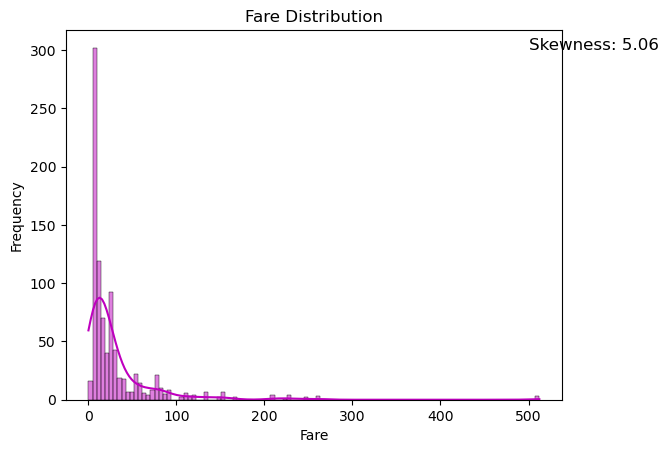

In [27]:
# Exploring Fare Distribution
sns.histplot(train_data["Fare"], color="m", kde=True)
plt.title("Fare Distribution")
plt.xlabel("Fare")
plt.ylabel("Frequency")
plt.text(500, 300, "Skewness: %.2f" % train_data["Fare"].skew(), fontsize=12)
plt.show()

In [28]:
# Apply log to Fare to reduce skewness distribution
transformer = FunctionTransformer(np.log1p, validate=True)

# Obtain logarithmic values
train_data_transformed = transformer.transform(train_data[["Fare"]])
train_data_outliers_transformed = transformer.transform(train_data_outliers[["Fare"]])
test_data_transformed = transformer.transform(test_data[["Fare"]])

# Replace the real values with the logarithmic ones
train_data["Fare"] = train_data_transformed
train_data_outliers["Fare"] = train_data_outliers_transformed
test_data["Fare"] = test_data_transformed

C:\Users\Mitko Stoychev\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but FunctionTransformer was fitted without feature names
  warnings.warn(
C:\Users\Mitko Stoychev\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but FunctionTransformer was fitted without feature names
  warnings.warn(
C:\Users\Mitko Stoychev\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but FunctionTransformer was fitted without feature names
  warnings.warn(


C:\Users\Mitko Stoychev\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


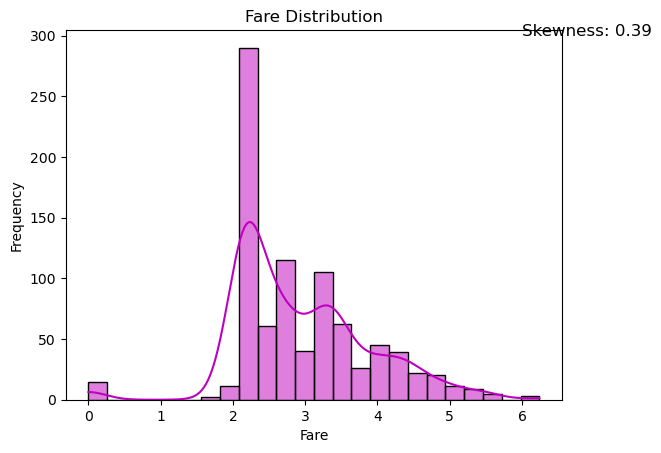

In [29]:
# Exploring Fare Distribution
sns.histplot(train_data["Fare"], color="m", kde=True)
plt.title("Fare Distribution")
plt.xlabel("Fare")
plt.ylabel("Frequency")
plt.text(6, 300, "Skewness: %.2f" % train_data["Fare"].skew(), fontsize=12)
plt.show()

I can confirm that skewness is clearly reduced.

I will now proceed to Feature Scaling with the Standarization method.

In [30]:
scaler = StandardScaler()
columns_to_scale = ["Age", "SibSp", "Parch", "Fare", "family_size"]

# Extract the subset of columns to scale
train_data_subset = train_data[columns_to_scale]
train_data_outliers_subset = train_data_outliers[columns_to_scale]
test_data_subset = test_data[columns_to_scale]

# Fit and transform the training data with the scaler
train_data_scaled = scaler.fit_transform(train_data_subset)
train_data_scaled = pd.DataFrame(train_data_scaled, columns=columns_to_scale)
# Transform the outliers data using the same scaler
train_data_outliers_scaled = scaler.transform(train_data_outliers_subset)
train_data_outliers_scaled = pd.DataFrame(train_data_outliers_scaled, columns=columns_to_scale)
# Fit and transform the test data with the scaler
test_data_scaled = scaler.fit_transform(test_data_subset)
test_data_scaled = pd.DataFrame(test_data_scaled, columns=columns_to_scale)

# Concatenate the scaled columns with the original datasets
train_data = pd.concat([train_data.drop(columns=columns_to_scale), train_data_scaled], axis=1)
train_data_outliers = pd.concat([train_data_outliers.drop(columns=columns_to_scale), train_data_outliers_scaled], axis=1)
# Concatenate the scaled columns with the original datasets
test_data = pd.concat([test_data.drop(columns=columns_to_scale), test_data_scaled], axis=1)

train_data.head(5)

,PassengerId,Survived,Pclass,onehotencoder__Sex_female,onehotencoder__Sex_male,onehotencoder__Embarked_C,onehotencoder__Embarked_Q,onehotencoder__Embarked_S,Age,SibSp,Parch,Fare,family_size
0,1,0,3,0.0,1.0,0.0,0.0,1.0,-0.592011,0.625474,-0.458969,-0.872244,0.131479
1,2,1,1,1.0,0.0,1.0,0.0,0.0,0.633114,0.625474,-0.458969,1.400796,0.131479
2,3,1,3,1.0,0.0,0.0,0.0,1.0,-0.285730,-0.522532,-0.458969,-0.789882,-0.592476
3,4,1,1,1.0,0.0,0.0,0.0,1.0,0.403403,0.625474,-0.458969,1.097331,0.131479
4,5,0,3,0.0,1.0,0.0,0.0,1.0,0.403403,-0.522532,-0.458969,-0.775315,-0.592476


# 3. Modeling 
### <font color="red">  *without outliers* <font>

In [31]:
# Define X and y
X_train = train_data.drop(["Survived"], axis=1)
y_train = train_data["Survived"]

## 3.1. Simple Modelling
### 3.1.1. Cross Validation Modelling
I compared 4 popular classifiers and evaluate the mean accuracy of each of them by a stratified kfold cross validation procedure.
In my prediction I´m going to use the next 4 models:
1. Decision Tree
2. Random Forest
3. KNN4. 
Logistic regression

In [32]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

In [33]:
random_state = 7

# Define the models
model_dtc = DecisionTreeClassifier(random_state=random_state)
model_rfc = RandomForestClassifier(random_state=random_state)
model_KNN = KNeighborsClassifier()
model_lg = LogisticRegression(random_state = random_state)
model_gbc = GradientBoostingClassifier(random_state = random_state)

# append the models in a list
classifier_models = []
classifier_models.append(model_dtc)
classifier_models.append(model_rfc)
classifier_models.append(model_KNN)
classifier_models.append(model_lg)
classifier_models.append(model_gbc)

In [34]:
# Cross Validation Modelling
cv_results = []
for curr_model in classifier_models :
    cv_results.append(cross_val_score(
        curr_model, 
        X_train, 
        y = y_train, 
        scoring = "accuracy", 
        cv = kfold, 
        n_jobs=-1     #I have only one CPU
    ))

In [35]:
cv_results

[array([0.48314607, 0.76136364, 0.72727273, 0.61363636, 0.65909091,
        0.76136364, 0.84090909, 0.77272727, 0.80681818, 0.80681818]),
 array([0.69662921, 0.79545455, 0.72727273, 0.82954545, 0.89772727,
        0.81818182, 0.84090909, 0.78409091, 0.84090909, 0.85227273]),
 array([0.41573034, 0.61363636, 0.36363636, 0.46590909, 0.40909091,
        0.46590909, 0.375     , 0.45454545, 0.44318182, 0.61363636]),
 array([0.79775281, 0.78409091, 0.76136364, 0.875     , 0.78409091,
        0.77272727, 0.78409091, 0.78409091, 0.78409091, 0.81818182]),
 array([0.57303371, 0.73863636, 0.76136364, 0.78409091, 0.84090909,
        0.81818182, 0.82954545, 0.76136364, 0.82954545, 0.84090909])]

In [36]:
cv_means = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())

cv_res = pd.DataFrame({"cross_val_mean": cv_means, "Algorithms": ["Decision Tree", "Random Forest", "K-Nearest Neighbors", "Logistic Regression", "Gradient Boosting"]})

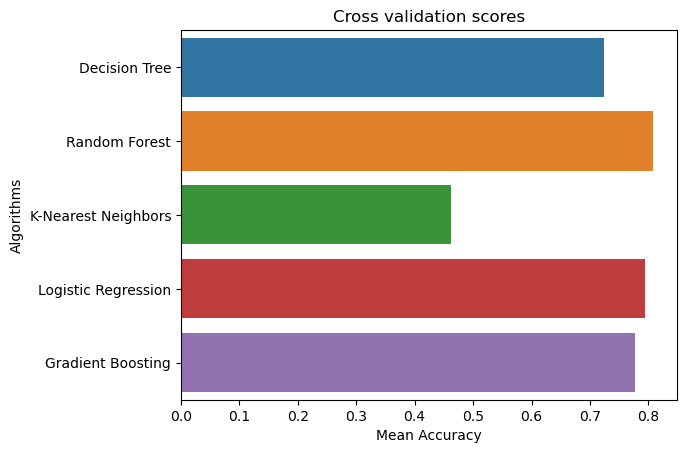

In [37]:
plot = sns.barplot(x="cross_val_mean", y="Algorithms",data = cv_res, orient = "h")
plot.set_xlabel("Mean Accuracy")
plot = plot.set_title("Cross validation scores")

## 3.1.2 Hyperparameter optimization for best models
I performed a Grid Search Optimization for RanfomForestClassifier and GradientBoostingClassifier.

In [38]:
# RANDOM FOREST CLASSIFIER  → OPTIMIZATION
## Search grid for optimal parameters
param_grid_rfc = {
    "max_depth": [None, 3, 5, 10],
    "min_samples_split": [2, 8, 10, 15],
    "min_samples_leaf": [1, 3, 5, 8, 10],
    "criterion": ["gini", "entropy"]
}

gs_rfc = GridSearchCV(model_rfc, param_grid = param_grid_rfc, cv=kfold, scoring="accuracy", n_jobs= -1) # n_jobs= -1, I have only 1 cpu
gs_rfc.fit(X_train, y_train)

rfc_best = gs_rfc.best_estimator_

# Best score
gs_rfc.best_score_

0.8320224719101124

In [39]:
# GRADIENT BOOSTING CLASSIFIER  → OPTIMIZATION
param_grid_gbc = {
    'loss' : ["deviance", "exponential"],
    'n_estimators' : [100, 200, 300],
    'learning_rate': [0.1, 0.05, 0.01],
    'max_depth': [3, 4, 8],
    'min_samples_leaf': [4, 5, 6],
    "criterion": ["friedman_mse",  "squared_error"]
}

gs_gbc = GridSearchCV(model_gbc, param_grid = param_grid_gbc, cv=kfold, scoring="accuracy", n_jobs= -1)  # n_jobs= -1, I have only 1 cpu

gs_gbc.fit(X_train, y_train)

gbc_best = gs_gbc.best_estimator_

# Best score
gs_gbc.best_score_

0.8286006128702759

### 3.1.3 Plot learning curves
Learning curves are a good way to see the overfitting effect on the training set and the effect of the training size on the accuracy.

In [40]:
def plot_learning_curve(estimator, title, X, y, ylim=(0, 1.2) , cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.
    """
    plt.figure()
    plt.title(title)
    plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    
    return plt

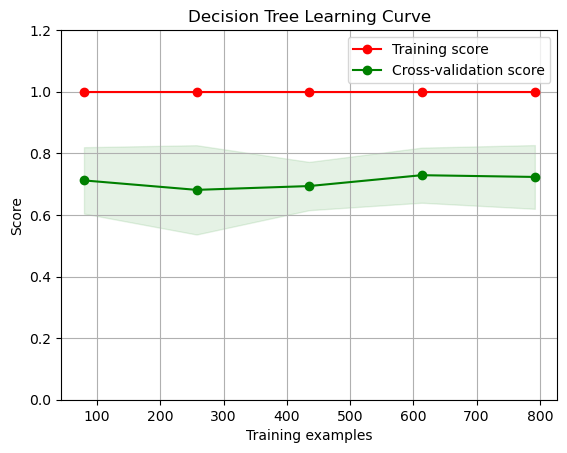

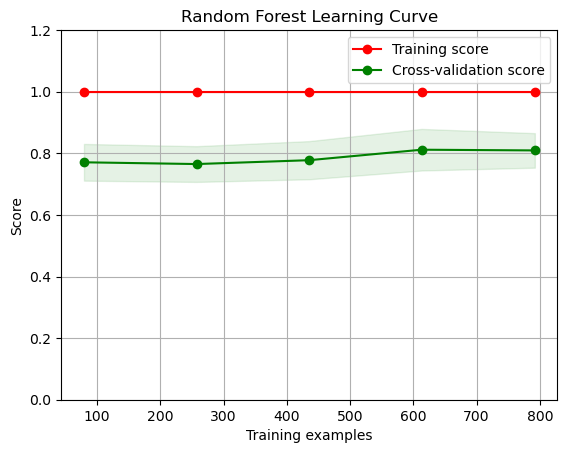

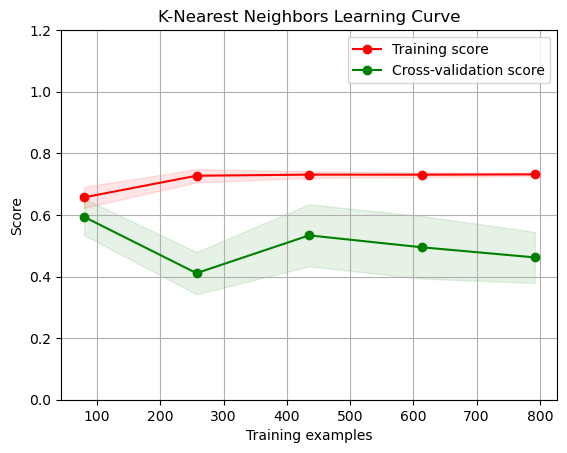

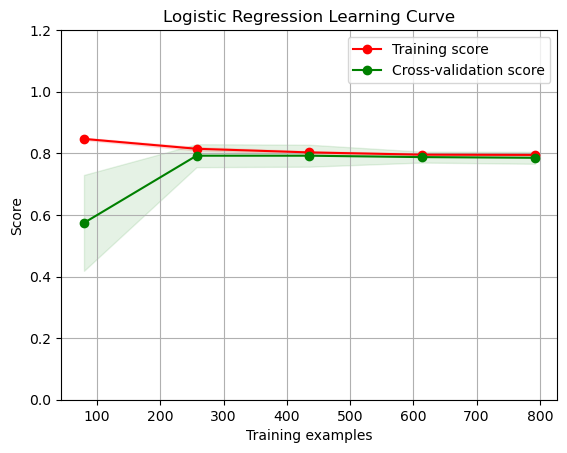

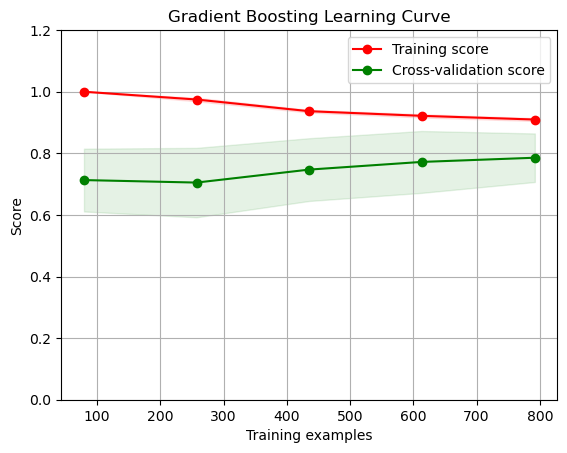

In [41]:
# Plot learning curves for Decision Tree Classifier
plot_learning_curve(model_dtc, "Decision Tree Learning Curve", X_train, y_train, cv=kfold, n_jobs=-1)

# Plot learning curves for Random Forest Classifier
plot_learning_curve(model_rfc, "Random Forest Learning Curve", X_train, y_train, cv=kfold, n_jobs=-1)

# Plot learning curves for K-Nearest Neighbors (KNN)
plot_learning_curve(model_KNN, "K-Nearest Neighbors Learning Curve", X_train, y_train, cv=kfold, n_jobs=-1)

# Plot learning curves for Logistic Regression
plot_learning_curve(model_lg, "Logistic Regression Learning Curve", X_train, y_train, cv=kfold, n_jobs=-1)

# Plot learning curves for Gradient Boosting Classifier
plot_learning_curve(model_gbc, "Gradient Boosting Learning Curve", X_train, y_train, cv=kfold, n_jobs=-1)

plt.show()

Random Forest Classifier, a learning curve like this suggests that the model is working well on the dataset.

Gradient Boosting, the decrease in the training score and the stabilization of the cross-validation score are positive indicators that the model is learning properly and generalizing well to unseen data.

## 3.2 Ensemble modeling
### 3.2.1 Combining models
I choosed a Voting Classifier to combine the predictions coming from the 2 classifiers.

I´ve selected the argument "soft" wich predicts the class label based on the argmax of the sums of the predicted probabilities, which is recommended for an ensemble of well-calibrated classifiers.

In [42]:
voting_classifier = VotingClassifier(estimators=[('rfc', rfc_best), ('gbc', gbc_best)], voting='soft', n_jobs=-1)

voting_classifier = voting_classifier.fit(X_train, y_train)

# 4. Prediction
I will submit 3 results:
* Random Forest Classifier
* Gradient Boosting Classifier
* Ensemble Model from them both

Then I´ll repeat the process with the data, but I will not eliminate the outliers from the data and I´ll train the model again.
My first idea is that will not improve the result, but we´ll see.
That´s about Data Science, so let´s experiment with the data =)
## 4.1. Predict and submit results
<font color="green">  ***without outliers*** <font>

In [49]:
X_test = test_data

In [50]:
# random forest classifier
model_rfc.fit(X_train, y_train)
prediction_rfc = model_rfc.predict(X_test)

# random forest classifier tunned
prediction_rfc_optimized = gs_rfc.predict(X_test)

# gradient boosting classifier
model_gbc.fit(X_train, y_train)
prediction_gbc = model_gbc.predict(X_test)

# gradient boosting classifier tunned
prediction_gbc_optimized = gs_gbc.predict(X_test)

# Ensemble Model 
prediction_ensambe = voting_classifier.predict(X_test)

In [51]:
submission_1 = pd.DataFrame({
    "PassengerId": test_data["PassengerId"], 
    "Survived": prediction_rfc    
})

submission_2 = pd.DataFrame({
    "PassengerId": test_data["PassengerId"], 
    "Survived": prediction_rfc_optimized      
})

submission_3= pd.DataFrame({
    "PassengerId": test_data["PassengerId"], 
    "Survived": prediction_gbc    
})

submission_4 = pd.DataFrame({
    "PassengerId": test_data["PassengerId"], 
    "Survived": prediction_gbc_optimized       
})

submission_5 = pd.DataFrame({
    "PassengerId": test_data["PassengerId"], 
    "Survived": prediction_ensambe       
})

In [52]:
#Export it to CSV file for Kaggle Competition
submission_1.to_csv("kaggle solutions/submission_1.csv", index=False)
submission_2.to_csv("kaggle solutions/submission_2.csv", index=False)
submission_3.to_csv("kaggle solutions/submission_3.csv", index=False)
submission_4.to_csv("kaggle solutions/submission_4.csv", index=False)
submission_5.to_csv("kaggle solutions/submission_5.csv", index=False)

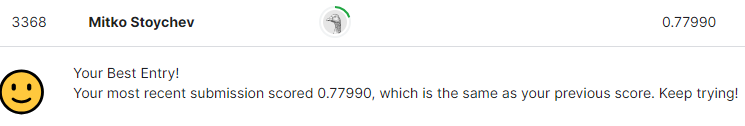

## 4.2. Predict and submit results
<font color="green">  ***with outliers*** <font>

In [53]:
# Define X and y → with outliers
X_train_outliers = train_data_outliers.drop(["Survived"], axis=1)
y_train_outliers = train_data_outliers["Survived"]

# train rfc model
model_rfc.fit(X_train_outliers, y_train_outliers)

#prediction rfc
prediction_rfc = model_rfc.predict(X_test)

#Grid search for rfc
gs_rfc_outlier = GridSearchCV(model_rfc, param_grid = param_grid_rfc, cv=kfold, scoring="accuracy", n_jobs= -1)

#train rfc optimized model
rfc_optimized = gs_rfc_outlier.fit(X_train_outliers, y_train_outliers)

#save rfc best estimator
rfc_best_outier = gs_rfc_outlier.best_estimator_

#predict rfc optimized model
prediction_rfc_optimized = rfc_optimized.predict(X_test)

In [54]:
# train gbc
model_gbc.fit(X_train_outliers, y_train_outliers)

# prediction gbc
prediction_gbc = model_gbc.predict(X_test)

# grid search for gbc
gs_gbc_outlier = GridSearchCV(model_gbc, param_grid = param_grid_gbc, cv=kfold, scoring="accuracy", n_jobs= -1) 

# train gbc optimized model
gbc_optimized = gs_gbc.fit(X_train_outliers, y_train_outliers)

#save gbc best estimator
gbc_best = gs_gbc.best_estimator_

# predict gbc optimized model
prediction_gbc_optimized = gbc_optimized.predict(X_test)

C:\Users\Mitko Stoychev\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


In [55]:
# ensemble model
voting_classifier = VotingClassifier(estimators=[('rfc', rfc_best_outier), ('gbc', gbc_best)], voting='soft', n_jobs=-1)

voting_classifier = voting_classifier.fit(X_train_outliers, y_train_outliers)

prediction_ensambe = voting_classifier.predict(X_test)

In [56]:
submission_6 = pd.DataFrame({
    "PassengerId": test_data["PassengerId"], 
    "Survived": prediction_rfc    
})

submission_7 = pd.DataFrame({
    "PassengerId": test_data["PassengerId"], 
    "Survived": prediction_rfc_optimized      
})

submission_8= pd.DataFrame({
    "PassengerId": test_data["PassengerId"], 
    "Survived": prediction_gbc    
})

submission_9 = pd.DataFrame({
    "PassengerId": test_data["PassengerId"], 
    "Survived": prediction_gbc       
})

submission_10 = pd.DataFrame({
    "PassengerId": test_data["PassengerId"], 
    "Survived": prediction_ensambe       
})

In [57]:
#Export it to CSV file for Kaggle Competition
submission_6.to_csv("kaggle solutions/submission_6.csv", index=False)
submission_7.to_csv("kaggle solutions/submission_7.csv", index=False)
submission_8.to_csv("kaggle solutions/submission_8.csv", index=False)
submission_9.to_csv("kaggle solutions/submission_9.csv", index=False)
submission_10.to_csv("kaggle solutions/submission_10.csv", index=False)

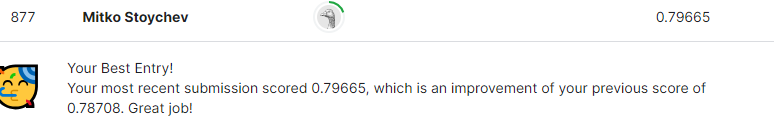